In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import pickle
import plotly.graph_objects as go

from utils.util import read_yaml
from box import Box

from utils.eda_tools import select_good_period, single_column_vis
import warnings
warnings.filterwarnings('ignore')

#### Load Data

In [74]:
cfg = Box(read_yaml('../src/conf/config.yaml'))
Config = Box(read_yaml('../src/conf/baseline.yaml'))

In [75]:
df_path = cfg.path.processed_data_new_tags
df = pd.read_csv(df_path, parse_dates=['Date'], index_col=0)

In [76]:
df.shape

(8700, 18)

In [77]:
df.head()

,OXO-5FI696 Augusta,OXO-5FIC600 Augusta,OXO-5FIC601 Augusta,OXO-5FIC608A Augusta,OXO-5FIC608B Augusta,OXO-5FIC612A Augusta,OXO-5FIC612B Augusta,OXO-5RIC606_Y Augusta,OXO-5TIC601 Augusta,OXO-5TIC603 Augusta,OXO-5TIC605B Augusta,OXO-5TIC606 Augusta,OXO-5TIC609 Augusta,month,day,day_of_week,week_of_year,kpi1
Date,,,,,,,,,,,,,,,,,,
2022-07-07 15:00:00,0.808354,18.164176,NaN,NaN,17.064672,NaN,NaN,NaN,15.237808,25.000000,25.000000,25.000000,NaN,7,7,3.0,27,NaN
2022-07-12 14:00:00,9732.920898,1969.954468,NaN,473.170868,24.567026,NaN,9.301239,211.847763,149.885101,131.856262,132.899979,133.078506,NaN,7,12,1.0,28,NaN
2022-07-12 15:00:00,9793.585449,2186.951233,NaN,563.453438,27.211921,NaN,9.298848,212.140929,150.012039,132.175243,133.049438,133.022430,NaN,7,12,1.0,28,NaN
2022-07-12 16:00:00,9787.632650,1908.431051,NaN,548.425631,25.253681,NaN,9.297150,212.209441,149.014712,132.101739,132.982583,132.906010,NaN,7,12,1.0,28,NaN
2022-07-12 17:00:00,9813.298177,2093.766357,NaN,537.335083,NaN,NaN,9.296973,212.083270,144.852333,131.996452,133.114178,133.100356,NaN,7,12,1.0,28,NaN


In [78]:
tag_list = list(df.columns)[1:-1]
len(tag_list)

16

In [79]:
# Create a dictionary to map the category to each tag
tag_df = pd.read_excel(cfg.path.tags_info)
# delete the first 3 str characters in the tag name
tag_df['Tag'] = tag_df['Tag'].apply(lambda x: x[3:])
# convert the . into - in the tag name
tag_df['Tag'] = tag_df['Tag'].apply(lambda x: x.replace('.', '-'))

tag_dict = dict(zip(tag_df['Tag'], tag_df['Category']))
print(tag_dict)

{'OXO-5FI635C Augusta': 'Measurement', 'OXO-5FI661A Augusta': 'Measurement', 'OXO-5FI696 Augusta': 'Independent', 'OXO-5FIC132 Augusta': 'Independent', 'OXO-5FIC600 Augusta': 'Target', 'OXO-5FIC601 Augusta': 'Target', 'OXO-5FIC602 Augusta': 'Control', 'OXO-5FIC603 Augusta': 'Control', 'OXO-5FIC606A Augusta': 'Control', 'OXO-5FIC606C Augusta': 'Control', 'OXO-5FIC607 Augusta': 'Control', 'OXO-5FIC609A Augusta': 'Target', 'OXO-5FIC609B Augusta': 'Control', 'OXO-5FIC611A Augusta': 'Control', 'OXO-5FIC611B Augusta': 'Control', 'OXO-5FIC612A Augusta': 'Target', 'OXO-5FIC612B Augusta': 'Target', 'OXO-5FIC618A Augusta': 'Control', 'OXO-5FIC618B Augusta': 'Control', 'OXO-5FIC618C Augusta': 'Control', 'OXO-5FIC618D Augusta': 'Control', 'OXO-5FIC622A Augusta': 'Control', 'OXO-5FIC622B Augusta': 'Control', 'OXO-5FIC622C Augusta': 'Control', 'OXO-5FIC636A Augusta': 'Control', 'OXO-5FIC636B Augusta': 'Control', 'OXO-5FIC636C Augusta': 'Control', 'OXO-5FQI691B Augusta': 'Measurement', 'OXO-5LI633B A

In [80]:
# # find tag in tag_list which has Control value in tag_dict
# ctrl_tag = [tag for tag in tag_list if tag_dict[tag] == 'Control']
# print(len(ctrl_tag))
# # the rest of the tags are independent tags
# ind_tag = [tag for tag in tag_list if tag_dict[tag] != 'Control']
# len(ind_tag)

#### Hyperparameters Tuning and Model Evaluation

In [81]:
from sklearn.model_selection import train_test_split

X = df[tag_list]
y = df[cfg.kpi1.tag1]

# use the data in df from 08/21/2023 as the test data
X_test = X.loc['2023-09-01':]
y_test = y.loc['2023-09-01':]

X_dev = X.loc[:'2023-09-01']
y_dev = y.loc[:'2023-09-01']

X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.1, shuffle=False, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X, y, **Config.xgboost_regressor_config.train_config)


X_train.shape, X_val.shape, X_test.shape

((7419, 16), (825, 16), (480, 16))

In [82]:
# visualize the distribution of the target variable using plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=y.index, y=y, mode='lines', name='target'))
fig.show()

In [83]:
import optuna
from sklearn.metrics import mean_squared_error
from math import sqrt

# Define the objective function to be optimized
def objective(trial):
    # Define the search space for hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 1000, 10000, step=1000),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'subsample': trial.suggest_uniform('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 10, 50),
    }

    # Create and train the XGBRegressor with the specified hyperparameters
    model = XGBRegressor(**params)
    model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_val, y_val)],
              verbose=False)

    # Evaluate the model on the validation set
    y_pred = model.predict(X_val)
    rmse = sqrt(mean_squared_error(y_val, y_pred))

    return rmse

In [84]:
# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2023-09-22 11:32:04,206] A new study created in memory with name: no-name-1fd202a6-9c18-4fc0-ab4a-94683ea02827


[I 2023-09-22 11:32:05,340] Trial 0 finished with value: 2371.962006935412 and parameters: {'n_estimators': 4000, 'max_depth': 2, 'learning_rate': 0.007187553165861533, 'subsample': 0.33757436289913856, 'colsample_bytree': 0.562080839531774, 'min_child_weight': 7, 'reg_alpha': 0.6095347263628142, 'reg_lambda': 0.9788026486470623, 'early_stopping_rounds': 12}. Best is trial 0 with value: 2371.962006935412.
[I 2023-09-22 11:32:06,084] Trial 1 finished with value: 2846.7903257176176 and parameters: {'n_estimators': 6000, 'max_depth': 5, 'learning_rate': 0.07452506175763196, 'subsample': 0.8599884229817963, 'colsample_bytree': 0.9381416082782598, 'min_child_weight': 3, 'reg_alpha': 0.6882700395416753, 'reg_lambda': 0.5793438255244263, 'early_stopping_rounds': 34}. Best is trial 0 with value: 2371.962006935412.
[I 2023-09-22 11:32:10,179] Trial 2 finished with value: 2925.812430658492 and parameters: {'n_estimators': 2000, 'max_depth': 8, 'learning_rate': 0.004916865987333069, 'subsample': 

In [85]:
# Get the best hyperparameters
best_params = study.best_params
best_params

{'n_estimators': 10000,
 'max_depth': 1,
 'learning_rate': 0.0015134543130134355,
 'subsample': 0.43071101351532326,
 'colsample_bytree': 0.145517098847005,
 'min_child_weight': 5,
 'reg_alpha': 0.4230995620427284,
 'reg_lambda': 0.39138903714785694,
 'early_stopping_rounds': 25}

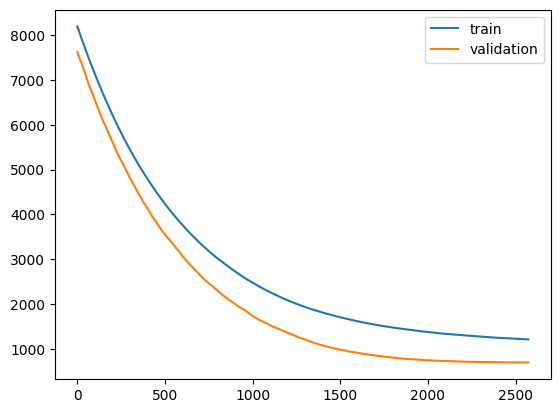

In [86]:
# my_model = XGBRegressor(**Config.xgboost_regressor_config.model_config)
my_model = XGBRegressor(**best_params)

my_model.fit(X_train, y_train, 
             eval_set=[(X_train, y_train),(X_val, y_val)], verbose=False)

results = my_model.evals_result()

# plot learning curves
plt.plot(results['validation_0']['rmse'], label='train')
plt.plot(results['validation_1']['rmse'], label='validation')
# show the legend
plt.legend()
# show the plot
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

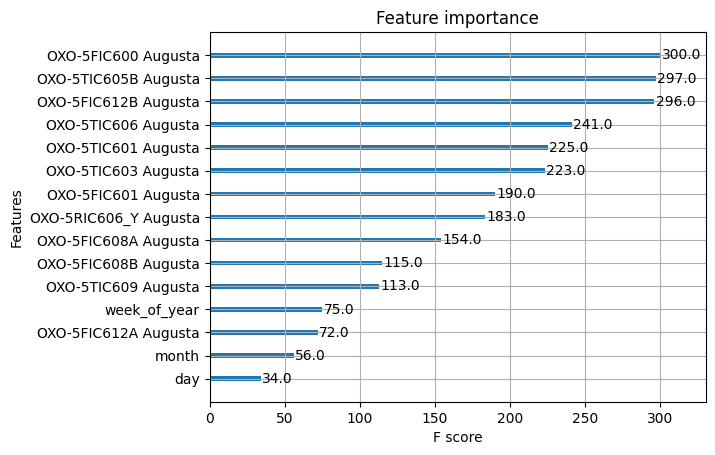

In [87]:
# plot the feature importance
from xgboost import plot_importance
plot_importance(my_model)

In [88]:
# save
# pickle.dump(my_model, open(Config.result_generating.v5.model_path, "wb"))

In [89]:
# calculate the rmse on train and test set
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score

y_train_pred = my_model.predict(X_train)
y_val_pred = my_model.predict(X_val)
y_test_pred = my_model.predict(X_test)

rmse_train = sqrt(mean_squared_error(y_train, y_train_pred))
rmse_val = sqrt(mean_squared_error(y_val, y_val_pred))
rmse_test = sqrt(mean_squared_error(y_test, y_test_pred))

print("RMSE on train set:", rmse_train)
print("RMSE on validation set:", rmse_val)
print("RMSE on test set:", rmse_test)

r2_train = r2_score(y_train, y_train_pred)
r2_val = r2_score(y_val, y_val_pred)
r2_test = r2_score(y_test, y_test_pred)

print("R2 on train set:", r2_train)
print("R2 on validation set:", r2_val)
print("R2 on test set:", r2_test)

RMSE on train set: 1213.6992765722266
RMSE on validation set: 693.9189169274398
RMSE on test set: 887.8530802359743
R2 on train set: 0.9037528239715837
R2 on validation set: 0.8835758688784238
R2 on test set: -0.1160447539145717


In [90]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_train.index, y=y_train, mode='lines', name='train'))
fig.add_trace(go.Scatter(x=y_train.index, y=y_train_pred, mode='lines', name='train_pred'))
fig.show()

In [91]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_val.index, y=y_val, mode='lines', name='val'))
fig.add_trace(go.Scatter(x=y_val.index, y=y_val_pred, mode='lines', name='val_pred'))
fig.show()

In [92]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test.index, y=y_test, mode='lines', name='test'))
fig.add_trace(go.Scatter(x=y_test.index, y=y_test_pred, mode='lines', name='test_pred'))
fig.show()

#### Optimization

In [24]:
from tqdm.notebook import tqdm_notebook

from utils.util import read_json, read_pickle, write_json
from utils.eda_tools import single_column_vis, lines_plot
from utils.optimization_result_vis import Controllable_Value_Plot

from optimization.Features import Feature_Info, get_feature_full_name
from optimization.Data import IncomingData, Missing_info
from optimization.Bounds import Bounds
from optimization.Dual_Annealing_Optimization import Dual_Annealing_Optimization

In [25]:
# ctrl_tag_length = len(ctrl_tag)
# difference_quantile = (df.iloc[:, :ctrl_tag_length].shift(1)-df.iloc[:, :ctrl_tag_length]).quantile(0.95)
difference_quantile = (df[ctrl_tag].shift(1)-df[ctrl_tag]).quantile(0.95)

# mean_of_controllable = df.iloc[:, :ctrl_tag_length].mean()
mean_of_controllable = df[ctrl_tag].mean()

ctrl_change_rate = (difference_quantile/mean_of_controllable).values

# Upper and Lower bounds historically, which directives can never exceed
quantile_lower = [df[tag].quantile(0.05) for tag in ctrl_tag]
quantile_upper = [df[tag].quantile(0.95) for tag in ctrl_tag]
bounds = [list(bound) for bound in zip(quantile_lower, quantile_upper)]

cont_dict = {tag:{'max_rate': rate,'bounds':bound} for tag,rate,bound in zip(ctrl_tag, ctrl_change_rate, bounds)}

# generate optimizer.json
opt_dict = dict()
opt_dict['controllable'] = cont_dict
opt_dict['noncontrollable'] = [tag for tag in ind_tag]

opt_dict['kwargs'] = {'maxiter': 10}
opt_dict['additional'] = {'tag2': [Config.kpi1.tag2], 'tag3': [Config.kpi1.tag3], 'tag4': [Config.kpi1.tag4], 'tag5': [Config.kpi1.tag5]}

In [26]:
opt_dict.keys()

dict_keys(['controllable', 'noncontrollable', 'kwargs', 'additional'])

In [27]:
denominator_tags = [Config.kpi1.tag2, Config.kpi1.tag3, Config.kpi1.tag4, Config.kpi1.tag5]
# test_df = df[denominator_tags+ctrl_tag+ind_tag].loc[Config.test_start_time:]
test_df = df[ctrl_tag+ind_tag].loc[Config.test_start_time:]

In [28]:
from datetime import datetime

tag1 = df[Config.kpi1.tag1].loc[Config.test_start_time:]
tag2 = df[Config.kpi1.tag2].loc[Config.test_start_time:]
tag3 = df[Config.kpi1.tag3].loc[Config.test_start_time:]
tag4 = df[Config.kpi1.tag4].loc[Config.test_start_time:]
tag5 = df[Config.kpi1.tag5].loc[Config.test_start_time:]

denominator = (tag2 + tag3)*1000 + tag4 + tag5
# convert into a list
denominator_list = denominator.values.tolist()

# get the index of the test_df in the datetime.datetime type, turn into a list
time_stamps = test_df.index.format()
time_stamps = [datetime.strptime(time_stamp, '%Y-%m-%d %H:%M:%S') for time_stamp in time_stamps]

In [29]:
test_df.columns = [column+'___Value' for column in test_df.columns]

features = Feature_Info(opt_dict)
incoming_data = IncomingData(test_df, features)

# bounds = Bounds(incoming_data).final_bounds()
bounds = [tuple(bound) for bound in zip(quantile_lower, quantile_upper)]

# my_model = pickle.load(open(Config.xgboost_regressor_config.v4_model_path, "rb"))
# Optimization = Dual_Annealing_Optimization(incoming_data, loaded_model, denominator_list, time_stamps)
Optimization = Dual_Annealing_Optimization(incoming_data, my_model)

In [30]:
nrows = incoming_data.value.shape[0]
optimal_controls = [None] * nrows
optimized_final_product = [None] * nrows

for i in tqdm_notebook(range(nrows)):
    timestamp = incoming_data.value.index[i]
    #bound = bounds[i]  
    bound = bounds
    
    optimal_controls_vals, optimized_product = Optimization.run_optimization(timestamp, bound)
    optimal_controls[i] = optimal_controls_vals
    optimized_final_product[i] = optimized_product

  0%|          | 0/4252 [00:00<?, ?it/s]

ValueError: Bounds are not consistent min < max

In [ ]:
test_df.columns = [column.replace('___Value', '') for column in test_df.columns]

In [ ]:
result_df = pd.DataFrame(optimal_controls, columns=[tag + '_Optimized' for tag in ctrl_tag], index=test_df.index[:nrows])
result_df['5FI696_optimized'] = np.array(optimized_final_product).flatten()
result_df['5FI696_before_optimized'] = (my_model.predict(test_df[ctrl_tag+ind_tag]))

In [ ]:
test_df.shape, result_df.shape

((2604, 57), (2604, 31))

In [ ]:
# save result_df to csv
result_df.to_csv(Config.result_generating.v5.result_df_path)

In [ ]:
final_df = pd.merge(result_df, test_df, left_index=True, right_index=True) # 62(60 cvs + 2 LNG) columns of the result_df + 584 columns of the test_df

In [ ]:
Controllables_number_in_one_plot = 7

In [ ]:
for i in range(len(ctrl_tag)//7):
    Controllable_Value_Plot(final_df, ctrl_tag[Controllables_number_in_one_plot*i:Controllables_number_in_one_plot*(i+1)]).write_html(Config.result_generating.v5.visualization.controllable_result_path[i])

In [ ]:
df_graph = pd.DataFrame()
df_graph['Actual 5FI696 Level'] = df[Config.kpi1.tag1].loc['2022-11-22 12:00:00':]
df_graph['Optimized 5FI696 Level'] = final_df['5FI696_optimized']
df_graph['Predicted 5FI696 Level'] = final_df['5FI696_before_optimized']

lines_plot(df_graph, ['Actual 5FI696 Level', 'Optimized 5FI696 Level', 'Predicted 5FI696 Level']).write_html(Config.result_generating.v5.visualization.optimized_target_level_path)

In [ ]:
kpi_before_optimized = final_df['5FI696_before_optimized']/ ((tag2 + tag3)*1000 + tag4 + tag5)
kpi_optimized = final_df['5FI696_optimized']/ ((tag2 + tag3)*1000 + tag4 + tag5)

In [ ]:
import plotly.graph_objects as go

trace1 = go.Scatter(x=kpi_optimized.index, y=kpi_before_optimized.values, name='kpi_before_optimized')
trace2 = go.Scatter(x=kpi_optimized.index, y=kpi_optimized.values, name='kpi_optimized')

# Create the figure and specify the layout
fig = go.Figure(data=[trace1, trace2])
fig.update_layout(title='kpi before and after optimization',
                xaxis_title='Date',
                yaxis_title='Kpi Value',
                width=1200,
                height=600)

# Display the plot
fig.show()

In [ ]:
# delete where kpi_optimized is larger than 2, leave the deleted as blank
kpi_optimized[kpi_optimized > 2] = np.nan
kpi_before_optimized[kpi_before_optimized > 2] = np.nan

In [ ]:
# make a dataframe of kpi_optimized and kpi_before_optimized as two columns
kpi_df = pd.DataFrame()
kpi_df['kpi_optimized'] = kpi_optimized
kpi_df['kpi_before_optimized'] = kpi_before_optimized
# save the dataframe as csv
kpi_df.to_csv(Config.result_generating.v5.kpi1_optimization_path)

In [ ]:
import plotly.graph_objects as go

trace1 = go.Scatter(x=kpi_optimized.index, y=kpi_before_optimized.values, name='kpi1_before_optimized')
trace2 = go.Scatter(x=kpi_optimized.index, y=kpi_optimized.values, name='kpi1_optimized')
layout = go.Layout(
    annotations=[
        dict(
            x=0,
            y=0.84,
            xref='paper',
            yref='y',
            text='0.84',
            showarrow=False,
            xanchor='right',
            yanchor='middle',
            font=dict(
                color='red'
            )
        ),
        dict(
            x=0,
            y=0.9,
            xref='paper',
            yref='y',
            text='0.9',
            showarrow=False,
            xanchor='right',
            yanchor='middle',
            font=dict(
                color='red'
            )
        )
    ]
)
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.update_layout(title='KPI1 Before and After Optimization',
                xaxis_title='Date',
                yaxis_title='Kpi1 Value',
                width=1200,
                height=600,
                yaxis=dict(
                    range=[0, 1.5],
                    showgrid=True
                    )
)
# Line Horizontal
fig.add_shape(
    type="line",
    x0=kpi_optimized.index[0],
    y0=0.84,
    x1=kpi_optimized.index[-1],
    y1=0.84,
    line=dict(
        color="black",
        width=2,
        dash="dashdot",
    ),
    name='target range'
)
fig.add_shape(
    type="line",
    x0=kpi_optimized.index[0],
    y0=0.9,
    x1=kpi_optimized.index[-1],
    y1=0.9,
    line=dict(
        color="black",
        width=2,
        dash="dashdot",
    ),
    name='target range'
)
fig.write_html(Config.result_generating.v5.visualization.kpi_before_and_after_optimization_path)
fig.show()

In [ ]:
from utils.optimization_result_vis import find_nearest_point

# Client's demand, for each time stamp, we use euclidean_dist algorithm to find the most similar point in the training data

TRAINING_TESTING_CUTOFF_DATE = '2022-01-01'

result = pd.DataFrame()
for i in range(final_df.shape[0]):
    temp = find_nearest_point(final_df.iloc[[i],:], df, ctrl_tag, TRAINING_TESTING_CUTOFF_DATE)
    result = pd.concat([result, temp])
result.index = final_df.index

In [ ]:
result = result.drop(columns=['Euclidean_Dist_Validation1', 'Euclidean_Dist_Validation2','Euclidean_Dist_Validation3','Euclidean_Dist_Validation4'])

In [ ]:
final_df = pd.concat([final_df, result], axis=1)
'''
final_df:
23(21 cvs + 1*2 LNG) columns of the result_df (optimized result)
+ 
197 columns of the test_df (original data, cvs + non-cvs)
+
84 (21 * 4) columns of the validation result for each cv
+
4 (1 * 4) columns of the validation timestamp (most similar timestamp to the current timestamp in terms of the 21 cvs) for the whole 21 cvs
'''

'\nfinal_df:\n23(21 cvs + 1*2 LNG) columns of the result_df (optimized result)\n+ \n197 columns of the test_df (original data, cvs + non-cvs)\n+\n84 (21 * 4) columns of the validation result for each cv\n+\n4 (1 * 4) columns of the validation timestamp (most similar timestamp to the current timestamp in terms of the 21 cvs) for the whole 21 cvs\n'

In [ ]:
final_df.to_csv(Config.result_generating.v4.outputing.output_path)

#### Validation

In [ ]:
final_df = pd.read_csv(Config.result_generating.v4.outputing.output_path, index_col=0, parse_dates=[0])
final_df.shape

(2604, 208)

In [ ]:
train_df = df[ctrl_tag].loc[:'2022-01-01']
train_df.shape

(17740, 29)

In [ ]:
test_df = df[ctrl_tag].loc['2022-01-01':]
test_df.shape

(8316, 29)

In [ ]:
# analyze the missing value of train_df
test_df.isnull().sum()

OXO-5FIC602 Augusta      0
OXO-5FIC603 Augusta      0
OXO-5FIC606A Augusta     0
OXO-5FIC606C Augusta     0
OXO-5FIC607 Augusta      0
OXO-5FIC609B Augusta     0
OXO-5FIC611A Augusta     0
OXO-5FIC611B Augusta     0
OXO-5FIC618A Augusta     0
OXO-5FIC618B Augusta     0
OXO-5FIC618C Augusta     0
OXO-5FIC618D Augusta     0
OXO-5FIC622A Augusta     0
OXO-5FIC622B Augusta     0
OXO-5FIC622C Augusta     0
OXO-5FIC636A Augusta     0
OXO-5FIC636B Augusta     0
OXO-5FIC636C Augusta     0
OXO-5PIC605A Augusta     0
OXO-5RIC606_Y Augusta    0
OXO-5TIC002 Augusta      0
OXO-5TIC601 Augusta      0
OXO-5TIC602 Augusta      0
OXO-5TIC603 Augusta      0
OXO-5TIC604 Augusta      0
OXO-5TIC605 Augusta      0
OXO-5TIC606 Augusta      0
OXO-5TIC607 Augusta      0
OXO-5TIC659 Augusta      0
dtype: int64

In [ ]:
# from utils.optimization_result_vis import generate_validation_result

# new_final_df = generate_validation_result(final_df, df, ctrl_tag, '2022-01-01')
# new_final_df

In [ ]:
# find the missing index of df2
missing_index = df[df.isnull().any(axis=1)].index
missing_index
# remove the missing index of df2
df = df.drop(missing_index)

In [ ]:
missing_index = final_df[final_df.isnull().any(axis=1)].index
len(missing_index)
# remove the missing index of final_df
final_df = final_df.drop(missing_index)

In [ ]:
# use the updated function in Jupyter notebook without restarting the kernel
import importlib
import utils.optimization_result_vis  # import the module

importlib.reload(utils.optimization_result_vis)  # reload the module

res = utils.optimization_result_vis.generate_validation_result(final_df, df, ctrl_tag, '2022-01-01')

In [ ]:
res.head()

,OXO-5FIC602 Augusta_Validation1,OXO-5FIC602 Augusta_Validation2,OXO-5FIC602 Augusta_Validation3,OXO-5FIC602 Augusta_Validation4,OXO-5FIC603 Augusta_Validation1,OXO-5FIC603 Augusta_Validation2,OXO-5FIC603 Augusta_Validation3,OXO-5FIC603 Augusta_Validation4,OXO-5FIC606A Augusta_Validation1,OXO-5FIC606A Augusta_Validation2,...,OXO-5TIC607 Augusta_Validation3,OXO-5TIC607 Augusta_Validation4,OXO-5TIC659 Augusta_Validation1,OXO-5TIC659 Augusta_Validation2,OXO-5TIC659 Augusta_Validation3,OXO-5TIC659 Augusta_Validation4,Nearest_TimeStamp_Validation1,Nearest_TimeStamp_Validation2,Nearest_TimeStamp_Validation3,Nearest_TimeStamp_Validation4
0,6531.939675,6531.973411,6431.586759,6596.24233,0.0,0.0,0.0,0.0,1123.137574,1122.718923,...,128.149784,129.328473,297.944153,298.025229,297.634313,297.350527,2021-03-27 10:00:00,2021-03-27 09:00:00,2021-03-27 20:00:00,2021-03-27 13:00:00
0,6531.939675,6531.973411,6431.586759,6596.24233,0.0,0.0,0.0,0.0,1123.137574,1122.718923,...,128.149784,129.328473,297.944153,298.025229,297.634313,297.350527,2021-03-27 10:00:00,2021-03-27 09:00:00,2021-03-27 20:00:00,2021-03-27 13:00:00
0,6150.402303,5644.628906,6724.570435,5686.979256,0.0,0.0,0.0,0.0,1037.099379,950.08885,...,128.683771,131.605484,296.844942,299.065742,297.074342,298.459857,2021-03-24 04:00:00,2021-03-25 09:00:00,2021-03-30 06:00:00,2021-03-25 14:00:00
0,6150.402303,5644.628906,6154.397253,6154.397253,0.0,0.0,0.0,0.0,1037.099379,950.08885,...,131.628986,131.610974,296.844942,299.065742,298.077669,298.016331,2021-03-24 04:00:00,2021-03-25 09:00:00,2021-03-24 08:00:00,2021-03-24 09:00:00
0,6150.402303,5644.628906,6724.570435,5711.037427,0.0,0.0,0.0,0.0,1037.099379,950.08885,...,128.683771,131.554933,296.844942,299.065742,297.074342,298.551559,2021-03-24 04:00:00,2021-03-25 09:00:00,2021-03-30 06:00:00,2021-03-25 16:00:00


In [ ]:
indices

NameError: name 'indices' is not defined

: 

In [ ]:
indices.shape

(8492, 4)

In [ ]:
res.to_csv(Config.result_generating.v3.outputing.output_path)